In [5]:
from itertools import combinations, product
list(combinations(["gt", "le"], 3))
list(product(["gt", "le"], repeat=3))

[('gt', 'gt', 'gt'),
 ('gt', 'gt', 'le'),
 ('gt', 'le', 'gt'),
 ('gt', 'le', 'le'),
 ('le', 'gt', 'gt'),
 ('le', 'gt', 'le'),
 ('le', 'le', 'gt'),
 ('le', 'le', 'le')]

In [56]:
%reload_kedro
train = catalog.load("train_data")
prepared_data = catalog.load("prepared_data")
test = catalog.load("test_data")
seg_metrics = catalog.load("seg_metrics")
seg_groups = catalog.load("seg_groups")

2022-02-03 19:53:44,346 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-02-03 19:53:44,384 - root - INFO - ** Kedro project time_series_kedro
2022-02-03 19:53:44,386 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-03 19:53:44,401 - root - INFO - Registered line magic `run_viz`
2022-02-03 19:53:44,403 - kedro.io.data_catalog - INFO - Loading data from `train_data` (CSVDataSet)...
2022-02-03 19:53:46,021 - kedro.io.data_catalog - INFO - Loading data from `prepared_data` (CSVDataSet)...
2022-02-03 19:53:46,050 - kedro.io.data_catalog - INFO - Loading data from `test_data` (CSVDataSet)...
2022-02-03 19:53:46,071 - kedro.io.data_catalog - INFO - Loading data from `seg_metrics` (CSVDataSet)...
2022-02-03 19:53:46,075 - kedro.io.data_catalog - INFO - Loading data from `seg_groups` (CSVDataSet)...


In [59]:
seg_metrics.corr()

,sample_entropy,cv,len_ts,acc_12m,adf
sample_entropy,1.000000,-0.707098,0.603126,-0.033596,-0.169326
cv,-0.707098,1.000000,-0.476228,-0.167972,-0.061142
len_ts,0.603126,-0.476228,1.000000,0.224550,0.028606
acc_12m,-0.033596,-0.167972,0.224550,1.000000,0.115074
adf,-0.169326,-0.061142,0.028606,0.115074,1.000000


In [66]:
series_ids = []
for i in range(1, 5):
    series_ids.append(seg_groups[seg_groups.group == i].iloc[0, 0])

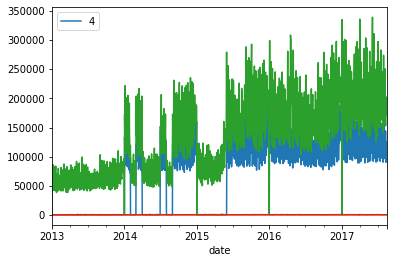

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i, serie_id in enumerate(series_ids):
    prepared_data[prepared_data.family == serie_id].set_index("date").sales.plot(ax=ax)
    ax.legend(f"{i+1}")

<AxesSubplot:xlabel='date'>

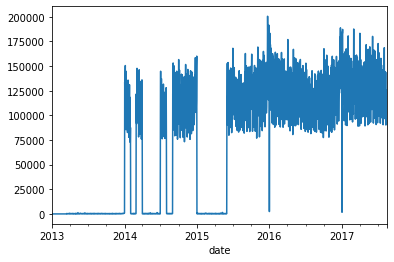

In [77]:
prepared_data[prepared_data.family == series_ids[0]].set_index("date").sales.plot()

<AxesSubplot:xlabel='date'>

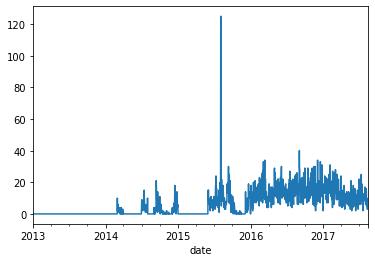

In [78]:
prepared_data[prepared_data.family == series_ids[1]].set_index("date").sales.plot()

<AxesSubplot:xlabel='date'>

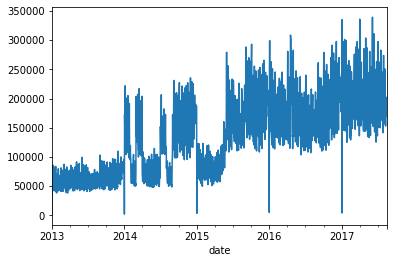

In [79]:
prepared_data[prepared_data.family == series_ids[2]].set_index("date").sales.plot()

<AxesSubplot:xlabel='date'>

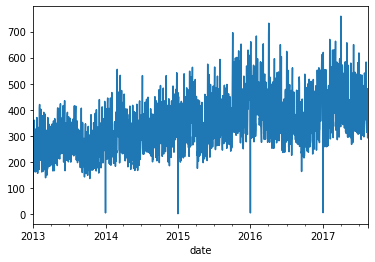

In [80]:
prepared_data[prepared_data.family == series_ids[3]].set_index("date").sales.plot()

In [10]:
group_divisions = catalog.load("params:group_divisions")
metrics = list(group_divisions)
metrics

2022-02-03 18:47:12,717 - kedro.io.data_catalog - INFO - Loading data from `params:group_divisions` (MemoryDataSet)...


['cv', 'acc_12m']

In [11]:
list(enumerate(product(["gt", "le"], repeat=len(metrics))))

[(0, ('gt', 'gt')), (1, ('gt', 'le')), (2, ('le', 'gt')), (3, ('le', 'le'))]

In [47]:
from typing import Any, Dict, List, Union
import numpy as np
import pandas as pd
from itertools import product
def time_series_segmentation(
    seg_metrics: pd.DataFrame, 
    group_divisions: Dict[str, Any]):
    
    metrics = list(group_divisions)
    n_groups = len(metrics) * 2
    seg_metrics["group"] = 0
    for i, group in enumerate(product(["gt", "le"], repeat=len(metrics))):
        series_filter = True 
        for comp, metric in zip(group, metrics):
            method = group_divisions[metric]["method"]
            args = group_divisions[metric]["args"]
            value = getattr(seg_metrics[metric], method)(*args)
            comp_filter = getattr(seg_metrics[metric], comp)(value)
            series_filter = series_filter & comp_filter
        seg_metrics.loc[series_filter, "group"] = i + 1
    return seg_metrics

In [48]:
list(product(["gt"], metrics))

[('gt', 'cv'), ('gt', 'acc_12m')]

In [49]:
list(enumerate((product(["gt", "le"], repeat=len(metrics)))))

[(0, ('gt', 'gt')), (1, ('gt', 'le')), (2, ('le', 'gt')), (3, ('le', 'le'))]

In [51]:
seg_groups = time_series_segmentation(seg_metrics, group_divisions)
seg_groups["gt_cv"] = seg_groups.cv > seg_groups.cv.mean()
seg_groups["le_cv"] = seg_groups.cv <= seg_groups.cv.mean()
seg_groups["gt_acc_12m"] = seg_groups.acc_12m > seg_groups.acc_12m.quantile(0.7)
seg_groups["le_acc_12m"] = seg_groups.acc_12m <= seg_groups.acc_12m.quantile(0.7)
seg_groups

('gt', 'gt')
gt cv
gt acc_12m
('gt', 'le')
gt cv
le acc_12m
('le', 'gt')
le cv
gt acc_12m
('le', 'le')
le cv
le acc_12m


,family,sample_entropy,cv,len_ts,acc_12m,group,gt_cv,le_cv,gt_acc_12m,le_acc_12m
0,AUTOMOTIVE,1.591288,0.328825,1687.0,4.778000e+03,4,False,True,False,True
1,BABY CARE,0.174098,1.035528,1264.0,1.100000e+02,2,True,False,False,True
2,BEAUTY,1.141865,0.500264,1688.0,4.515000e+03,4,False,True,False,True
3,BEVERAGES,0.703743,0.489593,1688.0,2.232985e+06,3,False,True,True,False
4,BOOKS,0.305768,1.139918,310.0,6.000000e+00,2,True,False,False,True
5,BREAD/BAKERY,1.092981,0.260016,1688.0,3.510338e+05,3,False,True,True,False
6,CELEBRATION,0.358858,0.650920,1323.0,8.369000e+03,2,True,False,False,True
7,CLEANING,1.216950,0.262718,1688.0,7.133300e+05,3,False,True,True,False
8,DAIRY,0.844186,0.358100,1688.0,5.362420e+05,3,False,True,True,False
9,DELI,1.185155,0.291274,1688.0,1.955421e+05,3,False,True,True,False


In [5]:
import pandas as pd
import numpy as np

In [6]:
prepared_data

,family,date,sales
0,AUTOMOTIVE,2013-01-01,0.000000
1,AUTOMOTIVE,2013-01-02,255.000000
2,AUTOMOTIVE,2013-01-03,161.000000
3,AUTOMOTIVE,2013-01-04,169.000000
4,AUTOMOTIVE,2013-01-05,342.000000
...,...,...,...
55699,SEAFOOD,2017-08-11,1272.615997
55700,SEAFOOD,2017-08-12,1028.030006
55701,SEAFOOD,2017-08-13,1118.047000
55702,SEAFOOD,2017-08-14,970.679999


In [8]:
seg_metrics.acc_12m.quantile(0.7)

184970.6468016

In [37]:
from time_series_kedro.extras.utils import rolling_fill
def build_series(serie_data, serie_target, date_col):
    serie = serie_data.set_index(date_col)[[serie_target]]
    full_serie = serie.reindex(pd.date_range(serie.index.min(), serie.index.max()))
    full_serie[serie_target] = rolling_fill(full_serie[serie_target], n=2)
    return full_serie
    
    

In [39]:
serie_target = "sales"
date_col = "date"
prepared_data.groupby("family").apply(lambda serie_data: build_series(serie_data, serie_target, date_col))

sales    0
dtype: int64

In [12]:
serie_data = prepared_data[prepared_data.family=="AUTOMOTIVE"].set_index("date")
serie_data

,family,sales
date,,
2013-01-01,AUTOMOTIVE,0.0
2013-01-02,AUTOMOTIVE,255.0
2013-01-03,AUTOMOTIVE,161.0
2013-01-04,AUTOMOTIVE,169.0
2013-01-05,AUTOMOTIVE,342.0
...,...,...
2017-08-11,AUTOMOTIVE,441.0
2017-08-12,AUTOMOTIVE,403.0
2017-08-13,AUTOMOTIVE,481.0


In [18]:
x = pd.DataFrame(data={"v":[1, 2, 3, 4, 5]}, index=[1, 3, 4, 5,7])
x.reindex([1, 2, 3, 4, 5, 6, 7])

,v
1,1
2,2
3,2
4,3
5,4
6,5
7,5


In [22]:
serie_data = prepared_data[prepared_data.family=="AUTOMOTIVE"].set_index("date")
serie_data = serie_data.reindex(pd.date_range(serie_data.index.min(), serie_data.index.max()))
serie_data[serie_id] = serie_data[serie_id].fillna("ffill")


In [6]:
pd.to_datetime(train.date)

id
0         2013-01-01
1         2013-01-01
2         2013-01-01
3         2013-01-01
4         2013-01-01
             ...    
3000883   2017-08-15
3000884   2017-08-15
3000885   2017-08-15
3000886   2017-08-15
3000887   2017-08-15
Name: date, Length: 3000888, dtype: datetime64[ns]

In [5]:
train.groupby("family").nunique().date

family
AUTOMOTIVE                    1684
BABY CARE                     1684
BEAUTY                        1684
BEVERAGES                     1684
BOOKS                         1684
BREAD/BAKERY                  1684
CELEBRATION                   1684
CLEANING                      1684
DAIRY                         1684
DELI                          1684
EGGS                          1684
FROZEN FOODS                  1684
GROCERY I                     1684
GROCERY II                    1684
HARDWARE                      1684
HOME AND KITCHEN I            1684
HOME AND KITCHEN II           1684
HOME APPLIANCES               1684
HOME CARE                     1684
LADIESWEAR                    1684
LAWN AND GARDEN               1684
LINGERIE                      1684
LIQUOR,WINE,BEER              1684
MAGAZINES                     1684
MEATS                         1684
PERSONAL CARE                 1684
PET SUPPLIES                  1684
PLAYERS AND ELECTRONICS       1684
POULTRY      